The code is borrowed from the following link \
[Original Code](https://github.com/lokesh-c-das/CS898BDDEEPLEARNING/tree/main)

### Importing Libraries

In [ ]:
import numpy as np
import collections
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Activation
from tensorflow.keras.layers import RNN, LSTM, GRU, SimpleRNN, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [ ]:
# ==============================================
# Data Loading and Exploration Functions
# ==============================================

def load_data(path):
    """
    Load data from a file
    """
    input_file = path
    with open(input_file, 'r', encoding='utf-8') as f:
        data = f.read()
    return data.split('\n')

# Load English data
english_sentences = load_data('data/small_vocab_en.txt')
# Load French data
french_sentences = load_data('data/small_vocab_fr.txt')

print('Dataset Loaded')
print(f'Number of English sentences: {len(english_sentences)}')
print(f'Number of French sentences: {len(french_sentences)}')

# Show sample sentences
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

# Count words in each language
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print(f'\nEnglish vocabulary statistics:')
print(f'Total English words: {len([word for sentence in english_sentences for word in sentence.split()])}')
print(f'Unique English words: {len(english_words_counter)}')
print('10 Most common English words:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')

print(f'\nFrench vocabulary statistics:')
print(f'Total French words: {len([word for sentence in french_sentences for word in sentence.split()])}')
print(f'Unique French words: {len(french_words_counter)}')
print('10 Most common French words:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

Dataset Loaded
Number of English sentences: 137861
Number of French sentences: 137861
small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

English vocabulary statistics:
Total English words: 1823250
Unique English words: 227
10 Most common English words:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

French vocabulary statistics:
Total French words: 1961295
Unique French words: 355
10 Most common French words:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [5]:
# ==============================================
# Data Preprocessing Functions
# ==============================================

def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    x_tk = Tokenizer(char_level=False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to. If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen=length, padding='post')

def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences (English)
    :param y: Label List of sentences (French)
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

# Preprocess the data
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = \
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index) + 1  # Adding 1 for padding token
french_vocab_size = len(french_tokenizer.word_index) + 1    # Adding 1 for padding token

print('\nData Preprocessed')
print(f"Max English sentence length: {max_english_sequence_length}")
print(f"Max French sentence length: {max_french_sequence_length}")
print(f"English vocabulary size: {english_vocab_size}")
print(f"French vocabulary size: {french_vocab_size}")


Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 200
French vocabulary size: 345


In [ ]:
# Split data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(
    preproc_english_sentences, preproc_french_sentences, test_size=0.15, random_state=42)

print(f"\nTraining set size: {len(train_x)}")
print(f"Validation set size: {len(val_x)}")


Training set size: 117181
Validation set size: 20680


In [44]:
# ==============================================
# Utility Functions
# ==============================================

def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'  # Add padding token

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

def get_random_test_sentences(num_samples=10):
    """
    Get random test sentences from validation set
    """
    test_indices = np.random.choice(len(val_x), num_samples, replace=False)
    test_x = val_x[test_indices]
    test_y = val_y[test_indices]
    
    return test_x, test_y, test_indices

In [8]:
# ==============================================
# Model Building Functions
# ==============================================

def stacked_rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a stacked (2-layer) RNN model for machine translation
    """
    learning_rate = 1e-3
    
    # Shape of input_shape is (batch_size, max_french_sequence_length, 1)
    input_seq = Input(input_shape[1:])
    
    # First RNN layer
    rnn_layer1 = SimpleRNN(128, return_sequences=True)(input_seq)
    
    # Second RNN layer
    rnn_layer2 = SimpleRNN(128, return_sequences=True)(rnn_layer1)
    
    # Output layer
    logits = TimeDistributed(Dense(french_vocab_size))(rnn_layer2)
    
    # Create and compile model
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy, 
                  optimizer=Adam(learning_rate), 
                  metrics=['accuracy'])
    
    return model

In [46]:
def stacked_lstm_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a stacked (2-layer) LSTM model for machine translation
    """
    learning_rate = 1e-3
    
    # Shape of input_shape is (batch_size, max_french_sequence_length, 1)
    input_seq = Input(input_shape[1:])
    
    # First LSTM layer
    lstm_layer1 = LSTM(128, return_sequences=True)(input_seq)
    
    # Second LSTM layer
    lstm_layer2 = LSTM(128, return_sequences=True)(lstm_layer1)
    
    # Output layer
    logits = TimeDistributed(Dense(french_vocab_size))(lstm_layer2)
    
    # Create and compile model
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy, 
                  optimizer=Adam(learning_rate), 
                  metrics=['accuracy'])
    
    return model



In [45]:
def stacked_gru_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a stacked (2-layer) GRU model for machine translation
    """
    learning_rate = 1e-3
    
    # Shape of input_shape is (batch_size, max_french_sequence_length, 1)
    input_seq = Input(input_shape[1:])
    
    # First GRU layer
    gru_layer1 = GRU(128, return_sequences=True)(input_seq)
    
    # Second GRU layer
    gru_layer2 = GRU(128, return_sequences=True)(gru_layer1)
    
    # Output layer
    logits = TimeDistributed(Dense(french_vocab_size))(gru_layer2)
    
    # Create and compile model
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy, 
                  optimizer=Adam(learning_rate), 
                  metrics=['accuracy'])
    
    return model

In [36]:
import time
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, model_name, train_x, train_y, val_x, val_y, epochs=20, batch_size=256):
    """
    Train and evaluate model with tracking of loss and accuracy metrics
    """
    print(f"\n=== Training {model_name} ===")
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    times = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Train the model for one epoch
        history = model.fit(
            train_x, train_y,
            batch_size=batch_size,
            epochs=1,  # Train for just one epoch
            validation_data=(val_x, val_y),
            verbose=0  # We'll print our own progress
        )
        
        # Get metrics from this epoch
        train_loss = history.history['loss'][0]
        train_acc = history.history['accuracy'][0]
        val_loss = history.history['val_loss'][0]
        val_acc = history.history['val_accuracy'][0]
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Record elapsed time
        current_time = time.time() - start_time
        times.append(current_time)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'Time: {current_time:.2f}s')
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate total training time
    training_time = time.time() - start_time
    print(f"\nTraining time: {training_time:.2f} seconds")
    print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'times': times,
        'training_time': training_time,
        'final_accuracy': val_accuracies[-1]
    }

In [11]:

def predict_translations(model, test_x, model_name):
    """
    Generate translations from model
    """
    print(f"\n=== {model_name} Translations ===")
    
    # Make predictions
    predictions = model.predict(test_x)
    
    # Return translated texts
    translations = []
    for i, prediction in enumerate(predictions):
        translated_text = logits_to_text(prediction, french_tokenizer)
        translations.append(translated_text)
        
    return translations


In [12]:


def display_comparisons(test_indices, translations_rnn, translations_lstm, translations_gru):
    """
    Display source sentences and translations from all models
    """
    print("\n=== Translation Comparisons ===")
    
    for i, idx in enumerate(test_indices):
        original_eng = english_sentences[idx]
        original_fr = french_sentences[idx]
        
        print(f"\nSample {i+1}:")
        print(f"English: {original_eng}")
        print(f"Real French: {original_fr}")
        print(f"RNN Translation: {translations_rnn[i]}")
        print(f"LSTM Translation: {translations_lstm[i]}")
        print(f"GRU Translation: {translations_gru[i]}")
        print("-" * 80)

In [13]:
# ==============================================
# Main Program Execution
# ==============================================

# Prepare data for RNN models - reshape
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Split reshaped data
train_x_reshaped, val_x_reshaped, train_y, val_y = train_test_split(
    tmp_x, preproc_french_sentences, test_size=0.15, random_state=42)

print(f"\nReshaped input shape: {tmp_x.shape[1:]}")

# Create models
rnn_model = stacked_rnn_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)
lstm_model = stacked_lstm_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)
gru_model = stacked_gru_model(tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)



Reshaped input shape: (21, 1)


In [47]:
# Get 10 random test sentences for translation
test_indices = np.random.choice(len(preproc_english_sentences), 10, replace=False)

# Reshape the test data the same way as training data
test_x = preproc_english_sentences[test_indices]
test_x = pad(test_x, max_french_sequence_length)
test_x = test_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

In [14]:
# Print model summaries
print("\nStacked RNN Model Summary:")
rnn_model.summary()

print("\nStacked LSTM Model Summary:")
lstm_model.summary()

print("\nStacked GRU Model Summary:")
gru_model.summary()


Stacked RNN Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 21, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 21, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 21, 345)        │        44,505 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,041 (367.35 KB)

 Trainable params: 94,041 (367.35 KB)

 Non-trainable params: 0 (0.00 B)


Stacked LSTM Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 21, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 21, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 21, 345)        │        44,505 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,649 (947.85 KB)

 Trainable params: 242,649 (947.85 KB)

 Non-trainable params: 0 (0.00 B)


Stacked GRU Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 21, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 21, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 21, 345)        │        44,505 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,881 (757.35 KB)

 Trainable params: 193,881 (757.35 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Set training parameters
EPOCHS = 10  # You can adjust this based on your needs
BATCH_SIZE = 256


=== Training Stacked RNN ===
Epoch [1/10], Train Loss: 0.5527, Train Acc: 0.8225, Val Loss: 0.5403, Val Acc: 0.8279, Time: 18.99s
Epoch [2/10], Train Loss: 0.5424, Train Acc: 0.8260, Val Loss: 0.5346, Val Acc: 0.8264, Time: 48.29s
Epoch [3/10], Train Loss: 0.5420, Train Acc: 0.8257, Val Loss: 0.5223, Val Acc: 0.8355, Time: 78.92s
Epoch [4/10], Train Loss: 0.5329, Train Acc: 0.8288, Val Loss: 0.5242, Val Acc: 0.8334, Time: 105.51s
Epoch [5/10], Train Loss: 0.5320, Train Acc: 0.8282, Val Loss: 0.5131, Val Acc: 0.8371, Time: 130.47s
Epoch [6/10], Train Loss: 0.5166, Train Acc: 0.8346, Val Loss: 0.5064, Val Acc: 0.8384, Time: 155.53s
Epoch [7/10], Train Loss: 0.5265, Train Acc: 0.8303, Val Loss: 0.5166, Val Acc: 0.8345, Time: 179.49s
Epoch [8/10], Train Loss: 0.5221, Train Acc: 0.8317, Val Loss: 0.5075, Val Acc: 0.8372, Time: 204.37s
Epoch [9/10], Train Loss: 0.4995, Train Acc: 0.8409, Val Loss: 0.4965, Val Acc: 0.8410, Time: 230.14s
Epoch [10/10], Train Loss: 0.5068, Train Acc: 0.8378, V

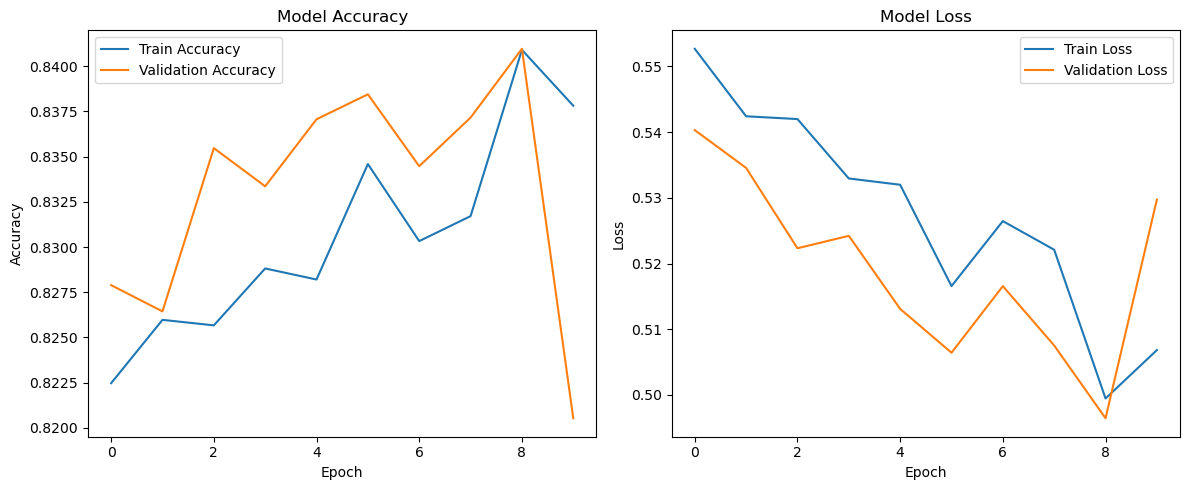


Training time: 254.95 seconds
Final validation accuracy: 0.8205


In [37]:

# Train models
train_losses, train_accuracies, val_losses, val_accuracies, times,   training_time, final_accuracy = train_and_evaluate_model(
    rnn_model, "Stacked RNN", train_x_reshaped, train_y, val_x_reshaped, val_y, EPOCHS, BATCH_SIZE)

In [25]:
# Generate translations from each model
translations_rnn = predict_translations(rnn_model, test_x, "Stacked RNN")


=== Stacked RNN Translations ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [24]:
translations_rnn

["la france est parfois le gel en l' mais il est est en novembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>",
 'la france est jamais relaxant en juillet et il est jamais agréable à juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 "l' inde est humide au janvier et il est doux en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>",
 'elle pense aller en inde en en dernier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'elle déteste les citrons verts les et les oranges <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'elle déteste les fraises citrons verts et les raisins <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'son fruit préféré est moins la raisin mais votre moins moins est la raisin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'notre fruits le plus aimé est la banane mais votre plus aimé est la citron <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'chine est jamais agréable gel en mais mais


=== Training Stacked LSTM ===
Epoch [1/10], Train Loss: 0.7296, Train Acc: 0.7679, Val Loss: 0.7209, Val Acc: 0.7673, Time: 46.12s
Epoch [2/10], Train Loss: 0.7076, Train Acc: 0.7747, Val Loss: 0.6988, Val Acc: 0.7771, Time: 91.43s
Epoch [3/10], Train Loss: 0.6848, Train Acc: 0.7824, Val Loss: 0.6747, Val Acc: 0.7842, Time: 138.91s
Epoch [4/10], Train Loss: 0.6669, Train Acc: 0.7873, Val Loss: 0.6634, Val Acc: 0.7869, Time: 186.15s
Epoch [5/10], Train Loss: 0.6501, Train Acc: 0.7922, Val Loss: 0.6392, Val Acc: 0.7947, Time: 288.68s
Epoch [6/10], Train Loss: 0.6329, Train Acc: 0.7981, Val Loss: 0.6240, Val Acc: 0.8029, Time: 413.94s
Epoch [7/10], Train Loss: 0.6174, Train Acc: 0.8028, Val Loss: 0.6083, Val Acc: 0.8039, Time: 538.99s
Epoch [8/10], Train Loss: 0.5992, Train Acc: 0.8096, Val Loss: 0.5853, Val Acc: 0.8147, Time: 592.74s
Epoch [9/10], Train Loss: 0.5866, Train Acc: 0.8136, Val Loss: 0.5804, Val Acc: 0.8178, Time: 641.85s
Epoch [10/10], Train Loss: 0.5716, Train Acc: 0.8187,

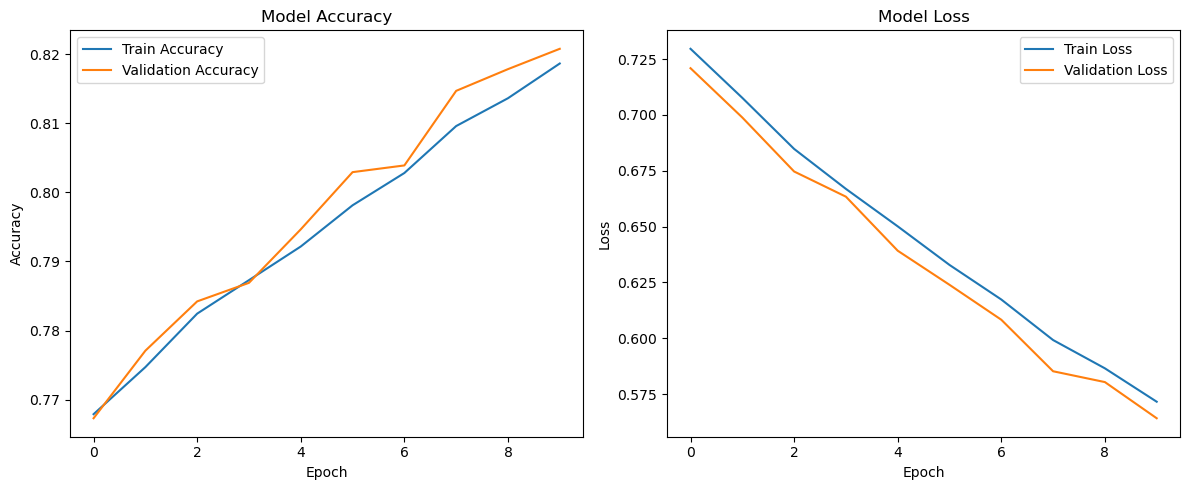


Training time: 700.94 seconds
Final validation accuracy: 0.8208


In [39]:
train_losses_LSTM, train_accuracies_LSTM, val_losses_LSTM, val_accuracies_LSTM, times_LSTM,   training_time_LSTM, final_accuracy_LSTM = train_and_evaluate_model(
    lstm_model, "Stacked LSTM", train_x_reshaped, train_y, val_x_reshaped, val_y, EPOCHS, BATCH_SIZE)

In [40]:

translations_lstm = predict_translations(lstm_model, test_x, "Stacked LSTM")


=== Stacked LSTM Translations ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step



=== Training Stacked GRU ===
Epoch [1/10], Train Loss: 0.6944, Train Acc: 0.7807, Val Loss: 0.6778, Val Acc: 0.7871, Time: 77.72s
Epoch [2/10], Train Loss: 0.6788, Train Acc: 0.7855, Val Loss: 0.6716, Val Acc: 0.7879, Time: 143.83s
Epoch [3/10], Train Loss: 0.6618, Train Acc: 0.7900, Val Loss: 0.6597, Val Acc: 0.7893, Time: 225.88s
Epoch [4/10], Train Loss: 0.6443, Train Acc: 0.7954, Val Loss: 0.6183, Val Acc: 0.8067, Time: 269.18s
Epoch [5/10], Train Loss: 0.6244, Train Acc: 0.8025, Val Loss: 0.6188, Val Acc: 0.8036, Time: 316.73s
Epoch [6/10], Train Loss: 0.6166, Train Acc: 0.8040, Val Loss: 0.5968, Val Acc: 0.8110, Time: 392.91s
Epoch [7/10], Train Loss: 0.6019, Train Acc: 0.8085, Val Loss: 0.5871, Val Acc: 0.8141, Time: 495.41s
Epoch [8/10], Train Loss: 0.5902, Train Acc: 0.8120, Val Loss: 0.5696, Val Acc: 0.8194, Time: 539.07s
Epoch [9/10], Train Loss: 0.5817, Train Acc: 0.8139, Val Loss: 0.5647, Val Acc: 0.8202, Time: 621.15s
Epoch [10/10], Train Loss: 0.5643, Train Acc: 0.8200,

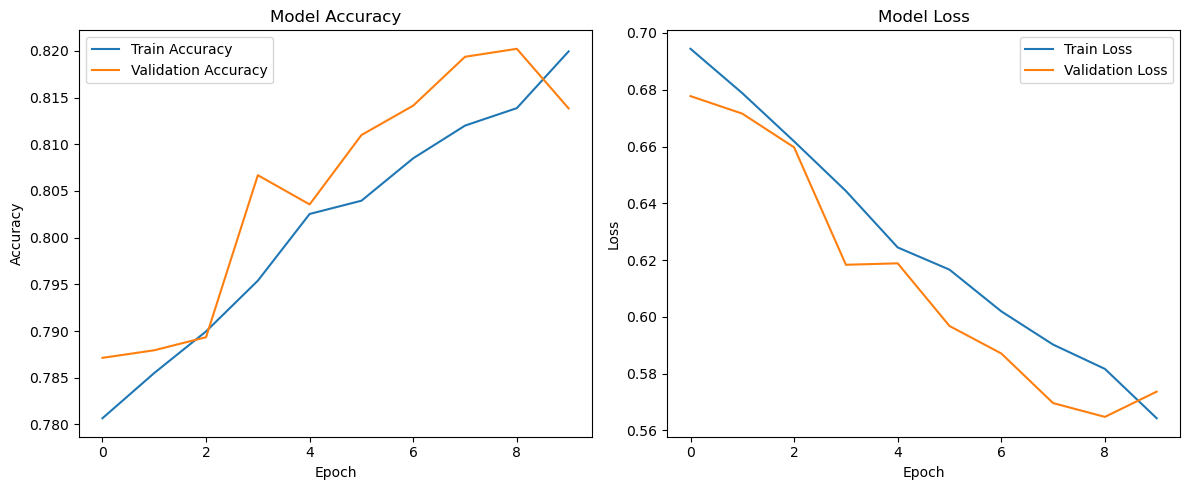


Training time: 680.46 seconds
Final validation accuracy: 0.8138


In [ ]:

train_losses_GRU, train_accuracies_GRU, val_losses_GRU, val_accuracies_GRU, times_GRU,   training_time_GRU, final_accuracy_GRU = train_and_evaluate_model(
    gru_model, "Stacked GRU", train_x_reshaped, train_y, val_x_reshaped, val_y, EPOCHS, BATCH_SIZE)


In [29]:
translations_gru = predict_translations(gru_model, test_x, "Stacked GRU")


=== Stacked GRU Translations ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


In [ ]:
from matplotlib.pyplot import plot as plt

# Plot training and validation losses
def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

In [30]:
# Display comparison of translations
display_comparisons(test_indices, translations_rnn, translations_lstm, translations_gru)


=== Translation Comparisons ===

Sample 1:
English: france is sometimes freezing during summer , but it is cold in november .
Real French: la france est parfois le gel pendant l' été , mais il est froid en novembre .
RNN Translation: la france est parfois le gel en l' mais il est est en novembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
LSTM Translation: la france est parfois agréable gel en mais mais mais est est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
GRU Translation: la france est parfois le gel pendant été été il il est en novembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
--------------------------------------------------------------------------------

Sample 2:
English: france is never relaxing during july , and it is never freezing in june .
Real French: la france est jamais relaxant en juillet , et il gèle jamais en juin .
RNN Translation: la france est jamais relaxant en juillet et il est jamais agréable à juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
LSTM Translatio